## Regression
**problem**: Chapter 6 of the textbook.

In this homework, you are asked to build a deep neural network model by using the backpropagation and stochastic gradient descent algorithm. You may design the network architecture by yourself, including **the number of hidden layers**, **the number of hidden units**, **learning rate**, **the number of epochs** and **mini-batch size**. Do not use available machine learning or deep learning packages
## Imports ##

In [1]:
%matplotlib inline
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import math
import random

## Load data
The training data is 75% data points of the dataset energy_efficiency_data.csv, and the test data is 25% data points of the dataset energy_efficiency_data.csv.


In [2]:
# Load the data into python and take a look
dataset = pd.read_csv(r'energy_efficiency_data.csv')
dataset.head()

,# Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
3,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
4,0.90,563.5,318.5,122.50,7.0,3,0.0,0,21.46,25.38


In [3]:
# Get more informations about dataset
dataset.describe()

,# Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [4]:
X = dataset.iloc[:,:8].values
y = dataset.iloc[:,8:10].values

## One-Hot Encode & Normalize ##
The categorical features (orientation, glazing area distribution) need to be encoded into one-hot vectors.
* Orientation
    * 2:north (1000)
    * 3:east  (0100)
    * 4:south (0010)
    * 5:west  (0001)
* Glazing area distribution
    * 1:uniform (10000)
    * 2:north   (01000)
    * 3:east    (00100)
    * 4:south   (00010)
    * 5:west    (00001)

Normalize the dataset.

In [5]:
# switch case for Orientation and Glazing Area Distribution encode
def one_hot_encode(feature, num):
    if feature == "orientation":
        numbers = {
            2 : [1, 0, 0, 0],
            3 : [0, 1, 0, 0],
            4 : [0, 0, 1, 0],
            5 : [0, 0, 0, 1]
        }
        return numbers.get(num, None)
    else:
        numbers = {
            0 : [0, 0, 0, 0, 0],
            1 : [1, 0, 0, 0, 0],
            2 : [0, 1, 0, 0, 0],
            3 : [0, 0, 1, 0, 0],
            4 : [0, 0, 0, 1, 0],
            5 : [0, 0, 0, 0, 1]
        }
        return numbers.get(num, None)

In [6]:
tmp = []
for x in X:
    # encode
    x = x.tolist()
    x[5:5] = one_hot_encode("orientation", x[5])
    del x[9]
    x[10:10] = one_hot_encode("glazing", x[10])
    del x[15]
    # normalize
    x[1] = x[1]/810
    x[2] = x[2]/420
    x[3] = x[3]/210
    x[4] = x[4]/7
    tmp.append(x)
X = np.array(tmp)

## Split Dataset ##
There are 2 simulation energy loads and 8 different features in this dataset. Shuffle the dataset then use 75% of data samples for training and 25% for testing.

In [7]:
# Splitting the dataset into training and testing set 75-25
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

X_train_seq, X_test_seq = X[:576,:], X[576:768,:]
y_train_seq, y_test_seq = y[:576], y[576:768]

In [8]:
dataset = []
for i, j in zip(X_train.tolist(), y_train.tolist()):
    dataset.append((i, [j[0]/45]))

dataset_seq = []
label_train_heating = []
label_train_cooling = []
label_test_heating = []
label_test_cooling = []
for i, j in zip(X_train_seq.tolist(), y_train_seq.tolist()):
    dataset_seq.append((i, [j[0]/45]))
for i in y_train_seq.tolist():
    label_train_heating.append(i[0]/45)
    label_train_cooling.append(i[1]/50)
for i in y_test_seq.tolist():
    label_test_heating.append(i[0]/45)
    label_test_cooling.append(i[1]/50)

Text(0.5,0,'#th case')

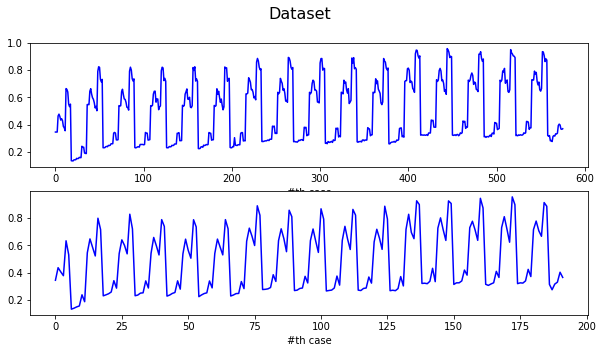

In [9]:
plt.figure(figsize=(10,5))
plt.suptitle('Dataset', fontsize=16)
plt.subplot(211)
plt.plot(range(576), label_train_heating, 'b-')
plt.xlabel('#th case')
plt.subplot(212)
plt.plot(range(192), label_test_heating, 'b-')
plt.xlabel('#th case')

## Neural Network ##

In [10]:
class NeuralNetwork(object):

    def __init__(self, learning_rate=0.5, debug=False):
        """
        Train NeuralNetwork by fixed learning rate
        """
        self.neuron_layers = []
        self.learning_rate = learning_rate
        self.debug = debug

    def train(self, dataset):
        for inputs, outputs in dataset:
            self.feed_forward(inputs)
            self.feed_backword(outputs)
            self.update_weights(self.learning_rate)

    def feed_forward(self, inputs):
        s = inputs
        for (i, l) in enumerate(self.neuron_layers):
            s = l.feed_forward(s)
            if self.debug:
                print ("Layer %s:" % (i+1), " output:%s" % s)
        return s

    def feed_backword(self, outputs):
        layer_num = len(self.neuron_layers)
        l = layer_num
        previous_deltas = [] 
        while l != 0:
            current_layer = self.neuron_layers[l - 1]
            if len(previous_deltas) == 0:
                for i in range(len(current_layer.neurons)):
                    error = -(outputs[i] - current_layer.neurons[i].output)
                    current_layer.neurons[i].calculate_delta(error)
            else:
                previous_layer = self.neuron_layers[l]
                for i in range(len(current_layer.neurons)):
                    error = 0
                    for j in range(len(previous_deltas)):
                        error += previous_deltas[j] * previous_layer.neurons[j].weights[i]
                    current_layer.neurons[i].calculate_delta(error)
            previous_deltas = current_layer.get_deltas()
            if self.debug:
                print ("Layer %s:" % l, "deltas:%s" % previous_deltas)
            l -= 1

    def update_weights(self, learning_rate):
        for l in self.neuron_layers:
            l.update_weights(learning_rate)

    def calculate_total_error(self, dataset):
        """
        Return mean squared error of dataset
        """
        total_error = 0
        for inputs, outputs in dataset:
            actual_outputs = self.feed_forward(inputs)
            for i in range(len(outputs)):
                total_error += (outputs[i] - actual_outputs[i]) ** 2
        return total_error

    def get_output(self, inputs):
        return self.feed_forward(inputs)

    def add_layer(self, neruon_layer):
        self.neuron_layers.append(neruon_layer)

    def dump(self):
        for (i, l) in enumerate(self.neuron_layers):
            print ("Dump layer: %s" % (i+1))
            l.dump()

In [11]:
class NeuronLayer(object):

    def __init__(self, input_num, neuron_num, init_weights=[], bias=1):
        self.neurons = []
        weight_index = 0
        for i in range(neuron_num):
            n = Neuron(input_num)
            for j in range(input_num):
                if weight_index < len(init_weights):
                    n.weights[j] = init_weights[weight_index]
                    weight_index += 1
            n.bias = bias
            self.neurons.append(n)

    def feed_forward(self, inputs):
        outputs = []
        for n in self.neurons:
            outputs.append(n.calculate_output(inputs))
        return outputs

    def get_deltas(self):
        return [n.delta for n in self.neurons]

    def update_weights(self, learning_rate):
        for n in self.neurons:
            n.update_weights(learning_rate)

    def dump(self):
        for (i, n) in enumerate(self.neurons):
            print ("\t-Dump neuron: %s" % (i+1))
            n.dump()

## Neuron ##
### Initialize the Weights of Neural Network ###
Using random function to randomly generate the weights.
### Calculate Output ###
$$z=\omega_{1}*x_{1}+\omega_{2}∗x_{2}+\omega_{3}∗bias$$

then using activation function(sigmoid function) to calculate the output

$$s=\frac{1}{1+e^{−z}}$$
### Activation Function ###
$$s=\frac{1}{1+e^{−z}}$$
### Calculate Delta ###
The error influence:
$$\delta_{L}=(realOutput−expectOutput)∗g′(z)$$

$$g'(z)=o∗(1−o)$$
### Update Weights ###
$$\delta_{L}=\omega_{L+1}\delta_{L+1}∗g′(z)$$

new weights: $$\omega_{i}=\omega_{i}−\alpha∗\delta∗x_{i}$$

new bias: $$\omega_{bias}=\omega_{bias}−\alpha∗\delta$$


In [12]:
class Neuron(object):

    def __init__(self, weight_num):
        self.weights = []
        self.bias = 0
        self.output = 0
        self.delta = 0
        self.inputs = []
        for i in range(weight_num):
            self.weights.append(random.random())

    def calculate_output(self, inputs):
        self.inputs = inputs
        if len(inputs) != len(self.weights):
            raise Exception("Input number not fit weight number")
        self.output = 0
        for (i, w) in enumerate(self.weights):
            self.output += w * inputs[i]
        self.output = self.activation_function(self.output + self.bias)
        return self.output

    def activation_function(self, x):
        """Using sigmoid function"""
        return 1 / (1 + math.exp(-x))

    def calculate_delta(self, error):
        """ Using g' of sigmoid """
        self.delta = error * self.output * (1 - self.output)

    def update_weights(self, learning_rate):
        for (i, w) in enumerate(self.weights):
            new_w = w - learning_rate * self.delta * self.inputs[i]
            self.weights[i] = new_w
        self.bias = self.bias - learning_rate * self.delta

    def dump(self):
        print ("\t\t-- weights:", self.weights)
        print ("\t\t-- bias:", self.bias)

## Train ##

In [13]:
nn = NeuralNetwork()
hidden_layer_1 = NeuronLayer(input_num=15, neuron_num=10, bias=1)
hidden_layer_2 = NeuronLayer(input_num=10, neuron_num=10, bias=1)
output_layer = NeuronLayer(input_num=10, neuron_num=1, bias=1)
nn.add_layer(hidden_layer_1)
nn.add_layer(hidden_layer_2)
nn.add_layer(output_layer)
# nn.dump()

tracking = []
for i in range(1000):
    nn.train(dataset)
    tracking.append(nn.calculate_total_error(dataset))

## Predit ##

In [14]:
predit_train_heating = []
predit_test_heating = []
for x in X_train_seq.tolist():
    predit_train_heating.append(nn.get_output(x))
for x in X_test_seq.tolist():
    predit_test_heating.append(nn.get_output(x))

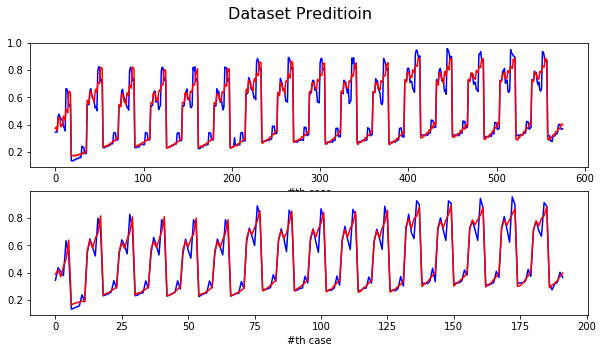

In [15]:
plt.figure(figsize=(10,5))
plt.suptitle('Dataset Preditioin', fontsize=16)

plt.subplot(211)
plt.plot(range(576), label_train_heating, 'b-')
plt.plot(range(576), predit_train_heating, 'r-')
plt.xlabel('#th case')

plt.subplot(212)
plt.plot(range(192), label_test_heating, 'b-')
plt.plot(range(192), predit_test_heating, 'r-')
plt.xlabel('#th case')

plt.savefig('1_Prediction')

In [41]:
predit_testing = []
for x in X_test.tolist():
    predit_testing.append(nn.get_output(x))

## Error ##

In [42]:
square_error = []
for (i, e) in enumerate(tracking):
    square_error.append(((e/len(dataset))*(45**2))**0.5)

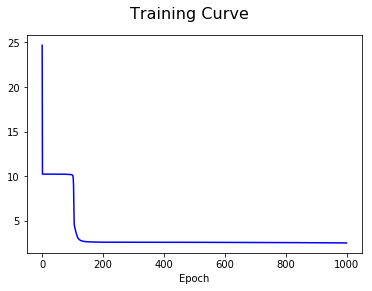

In [59]:
plt.suptitle('Training Curve', fontsize=16)
plt.plot(range(1000), square_error, 'b-')
plt.xlabel('Epoch')

plt.savefig('1_Training_Curve')

In [51]:
error_testing = 0
for y, t in zip(predit_testing, y_test):
    error_testing += (t[0]-y[0]*45)**2
error_testing = (error_testing/len(y_test))**0.5

In [58]:
print("Training RMS error: ", square_error[999])
print("Test RMS error: ", error_testing)

Training RMS error:  2.525849470116642
Test RMS error:  2.80324471719


In [16]:
print(len(nn.neuron_layers))

3
